In [1]:
import pandas as pd
import numpy as np
import math
import helper
import time
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, LeaveOneOut, ShuffleSplit, train_test_split, GridSearchCV 
from sklearn.feature_selection import SelectPercentile, SelectFromModel
import pickle    

# Подгрузка всех таблиц с данными по матчям

In [76]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium = pd.read_csv('../tabel/last day Before Tournament/table from Datdota/Rating teams/'+
                                      'PREMIUM on 2012-02-28 to 2018-04-10.csv', index_col=0)

# ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
df_contrpick = pd.read_csv(('../tabel/last day Before Tournament/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2012-02-28 to 2018-04-10 (ProTeam, more 20).csv'), index_col=0)

# ДФ с метовыми героями (PRO, >10)
df_meta_heroes = pd.read_csv('../tabel/last day Before Tournament/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2012-02-28 to 2018-04-10 (OneMonthAgo, All, more 20).csv', index_col=0)

# ДФ с сигнатурками для каждого игрока (ALL, >5)
df_signatures_heroes = pd.read_csv('../tabel/last day Before Tournament/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                                   'Players Signatures on 2012-02-28 to 2018-04-10 (All, more 5) (previosly day).csv', index_col=0)


In [77]:
# Обучение на дне перед ДАКом 2018
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium = pd.read_csv('../tabel/last day Before Tournament/table from Datdota/Rating teams/'+
                                      'PREMIUM on 2012-02-28 to 2018-04-10.csv', index_col=0)
print (len(df_rating_teams_Premium))
# ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
df_contrpick = pd.read_csv(('../tabel/last day Before Tournament/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2012-02-28 to 2018-03-28 (ProTeam, more 20).csv'), index_col=0)
print (len(df_contrpick))
# ДФ с метовыми героями (PRO, >10)
df_meta_heroes = pd.read_csv('../tabel/last day Before Tournament/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2012-02-28 to 2018-03-28 (OneMonthAgo, All, more 20).csv', index_col=0)
print (len(df_meta_heroes))
# ДФ с сигнатурками для каждого игрока (ALL, >5)
df_signatures_heroes = pd.read_csv('../tabel/last day Before Tournament/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                                   'Players Signatures on 2012-02-28 to 2018-03-28 (All, more 5) (previosly day).csv', index_col=0)
print (len(df_signatures_heroes))

4061
3926
3926
3926


In [78]:
# 3803473688  3823008429 
df_rating_teams_Premium = df_rating_teams_Premium[df_rating_teams_Premium['match_id'] <= 3701604989]

# Создание основного ДФ для обучения и предсказания

In [94]:
df_signatures_heroes = df_signatures_heroes[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
                                            'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
                                            'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
                                            'dire_P5_eloShift', 'match_id']]

# Соединение всех данных в один ДФ
main = pd.merge(df_rating_teams_Premium, df_contrpick, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_meta_heroes, left_on='match_id', right_on='match_id',how='left')
main = pd.merge(main, df_signatures_heroes, left_on='match_id', right_on='match_id',how='left')

# # удаление не нужных колонок для обучения
main = main.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
main = main.drop(main.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


# Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
main = main.drop(main.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
main = main.drop(main.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)

main = main.drop(main.loc[:, 'radiant_mu_glicko':'dire_ratingSevenDaysAgo_glicko2'], axis=1)

print (len(main))

3926


In [95]:
# Заполнить пустые значения на 0
# main = main.fillna(0)

# # убрать пустые ячейки
main = main.dropna()
len(main)


3919

In [96]:
main.columns

Index(['radiant_win', 'radiant_H1elo_vs_enemies', 'radiant_H2elo_vs_enemies',
       'radiant_H3elo_vs_enemies', 'radiant_H4elo_vs_enemies',
       'radiant_H5elo_vs_enemies', 'dire_H1elo_vs_enemies',
       'dire_H2elo_vs_enemies', 'dire_H3elo_vs_enemies',
       'dire_H4elo_vs_enemies', 'dire_H5elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift',
       'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift',
       'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift',
       'dire_P5_eloShift'],
      dtype='object')

In [51]:
main_DAC = (main[main["league_name"] == 'Dota 2 Asia Championships 2018'])

In [100]:
DAC = main_DAC[main_DAC['match_id'] > 3803473688]

# # удаление не нужных колонок для обучения
DAC = DAC.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)

print (DAC.columns)
X_contr = DAC.drop(['radiant_win'], axis=1)
y_contr = DAC['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y_contr = y_contr.astype(int)

Index(['radiant_win', 'radiant_H1elo_vs_enemies', 'radiant_H2elo_vs_enemies',
       'radiant_H3elo_vs_enemies', 'radiant_H4elo_vs_enemies',
       'radiant_H5elo_vs_enemies', 'dire_H1elo_vs_enemies',
       'dire_H2elo_vs_enemies', 'dire_H3elo_vs_enemies',
       'dire_H4elo_vs_enemies', 'dire_H5elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift',
       'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift',
       'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift',
       'dire_P5_eloShift'],
      dtype='object')


# Создание обучающих и тестовых данных

In [98]:
# сделать обучающие данные и ответы
X = main.drop(['radiant_win'], axis=1)
y = main['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y = y.astype(int)

# деление на тестовые и обучающую выборку
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
X_train.columns

Index(['radiant_H1elo_vs_enemies', 'radiant_H2elo_vs_enemies',
       'radiant_H3elo_vs_enemies', 'radiant_H4elo_vs_enemies',
       'radiant_H5elo_vs_enemies', 'dire_H1elo_vs_enemies',
       'dire_H2elo_vs_enemies', 'dire_H3elo_vs_enemies',
       'dire_H4elo_vs_enemies', 'dire_H5elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift',
       'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift',
       'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift',
       'dire_P5_eloShift'],
      dtype='object')

# Решетчатый поиск на Gradient Bosting

In [9]:
%%time
# Праметры GB
# param_grid = {'n_estimators': [25, 50, 100, 150], 'max_depth': [10, 25, 50, 100],
#               'max_features': [50, 100, 200, 300]}
param_grid = {'n_estimators': [100], 'max_depth': [10],
              'max_features': [40]}
grid_search_GB = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)

grid_search_GB.fit(X_train,y_train)


print("Наилучшие значения параметров: {}".format(grid_search_GB.best_params_))
print('----------------------------------------------------------------------')
print(classification_report(y_test, grid_search_GB.predict(X_test), target_names=['dire_win', 'radiant_win']))

Наилучшие значения параметров: {'max_depth': 10, 'max_features': 40, 'n_estimators': 100}
----------------------------------------------------------------------
             precision    recall  f1-score   support

   dire_win       0.72      0.72      0.72       452
radiant_win       0.74      0.74      0.74       481

avg / total       0.73      0.73      0.73       933

Wall time: 19.1 s


In [263]:
# # save the model to disk
# filename = 'grid_search_GB_model_Patch7.00+_2018.05.06.sav'
# pickle.dump(grid_search_GB, open(filename, 'wb'))

In [101]:
%%time
# ДАННЫЕ ПО HEAD-TO-HEAD ДЛЯ ВСЕХ ПАТЧЕЙ ДО ПРЕДЫДУЩЕГО ДНЯ МАТЧЯ
import xgboost as xgb
# fit model no training data
XGB = xgb.XGBClassifier()
XGB.fit(X_train, y_train)
print(classification_report(y_test, XGB.predict(X_test), target_names=['dire_win', 'radiant_win']))
print('----------------------------------------------------------------------------')
print(classification_report(y_contr, XGB.predict(X_contr), target_names=['dire_win', 'radiant_win']))

             precision    recall  f1-score   support

   dire_win       0.83      0.79      0.80       475
radiant_win       0.81      0.84      0.82       505

avg / total       0.82      0.82      0.82       980

----------------------------------------------------------------------------
             precision    recall  f1-score   support

   dire_win       0.78      0.78      0.78        40
radiant_win       0.85      0.85      0.85        60

avg / total       0.82      0.82      0.82       100

Wall time: 162 ms


In [24]:
# save the model to disk
filename = 'xgb_v.3.1.c.84 (without rating teams).sav'
pickle.dump(XGB, open(filename, 'wb'))

In [15]:
# test_gb = pickle.load(open(filename, 'rb'))
# test_gb.score(X_test, y_test)

In [115]:
model = XGB

# Проверка правильности данных

In [26]:
# main.loc[1500, 'radiant_H1elo_vs_enemies':]

In [15]:
import datetime
datetime.date.fromtimestamp(1502233763) - datetime.timedelta(1)

datetime.date(2017, 8, 8)

In [ ]:
df_meta_heroes[df_meta_heroes['match_id'] == 3274564960]

# Работа с фичами

In [141]:
best_GB = XGB
# предсказания
predict_GB = best_GB.predict(X_test)
# матрица ошибок
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predict_GB)
confusion

array([[286, 150],
       [132, 333]], dtype=int64)

In [142]:
# f1-мера
from sklearn.metrics import f1_score
f1_score(y_test, predict_GB)

0.70253164556962022

In [144]:

print(classification_report(y_test, predict_GB, target_names=['dire_win', 'radiant_win']))

             precision    recall  f1-score   support

   dire_win       0.68      0.66      0.67       436
radiant_win       0.69      0.72      0.70       465

avg / total       0.69      0.69      0.69       901



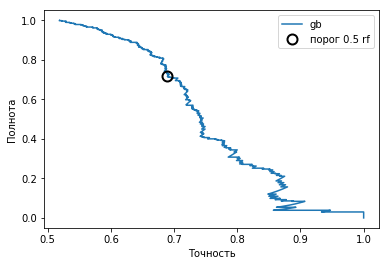

In [145]:
# в RandomForestClassifier есть predict_proba, но нет decision_function
precision_gb, recall_gb, thresholds_gb = metrics.precision_recall_curve(
y_test, best_GB.predict_proba(X_test)[:, 1])

plt.plot(precision_gb, recall_gb, label="gb")
close_default_gb = np.argmin(np.abs(thresholds_gb - 0.5))
plt.plot(precision_gb[close_default_gb], recall_gb[close_default_gb], 'o', c='k',
         markersize=10, label="порог 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Точность")
plt.ylabel("Полнота")
plt.legend(loc="best")
plt.show()

In [147]:
y_pred_lower_threshold = best_GB.predict_proba(X_test)[:,1] > .55
print (classification_report(y_test, y_pred_lower_threshold))

             precision    recall  f1-score   support

          0       0.67      0.72      0.69       436
          1       0.71      0.66      0.69       465

avg / total       0.69      0.69      0.69       901



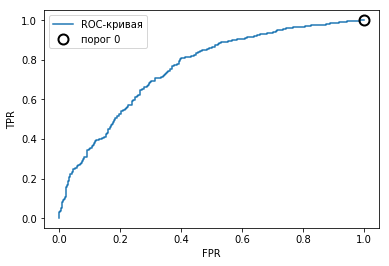

In [148]:
fpr, tpr, threshold = metrics.roc_curve(y_test, best_GB.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='ROC-кривая')
plt.xlabel('FPR')
plt.ylabel('TPR')
# находим пороговое значение ближайшее к нулю
close_zero = np.argmin(np.abs(threshold))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='порог 0', fillstyle='none', c='k', mew=2)
plt.legend(loc='best')
plt.show()

In [149]:
gb_auc = metrics.roc_auc_score(y_test, best_GB.predict_proba(X_test)[:,1])
print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc))

AUC для градиентного бустинга - 0.757


# Оценка качества признаков

In [150]:
# используем f_classif (по умолчанию)
# и SelectPercentile, чтобы выбрать 50% признаков
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)

print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (2701, 46)
форма массива X_train_selected: (2701, 23)


In [91]:
mask = select.get_support()
print (mask)
# визуализируем булевы значения: черный - true, булый - false
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Индекс')

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False  True False  True False
  True  True False False False False False False False False False False
  True  True  True  True False  True  True  True False False False False
 False False False False  True False False False  True  True False  True
  True False False False  True False False  True False  True  True  True
 False False False False]


Text(0.5,0,'Индекс')

In [92]:
X_test_selected = select.transform(X_test)
print ('Правильность со всеми признаками: {:.3f}'.format(best_GB.score(X_test, y_test)))
best_GB_selected_70 = xgb.XGBClassifier(max_depth=20)
best_GB_selected_70.fit(X_train_selected, y_train)
print ('Правильность с 50% признаками: {:.3f}'.format(best_GB_selected_70.score(X_test_selected, y_test)))

Правильность со всеми признаками: 0.690
Правильность с 50% признаками: 0.681


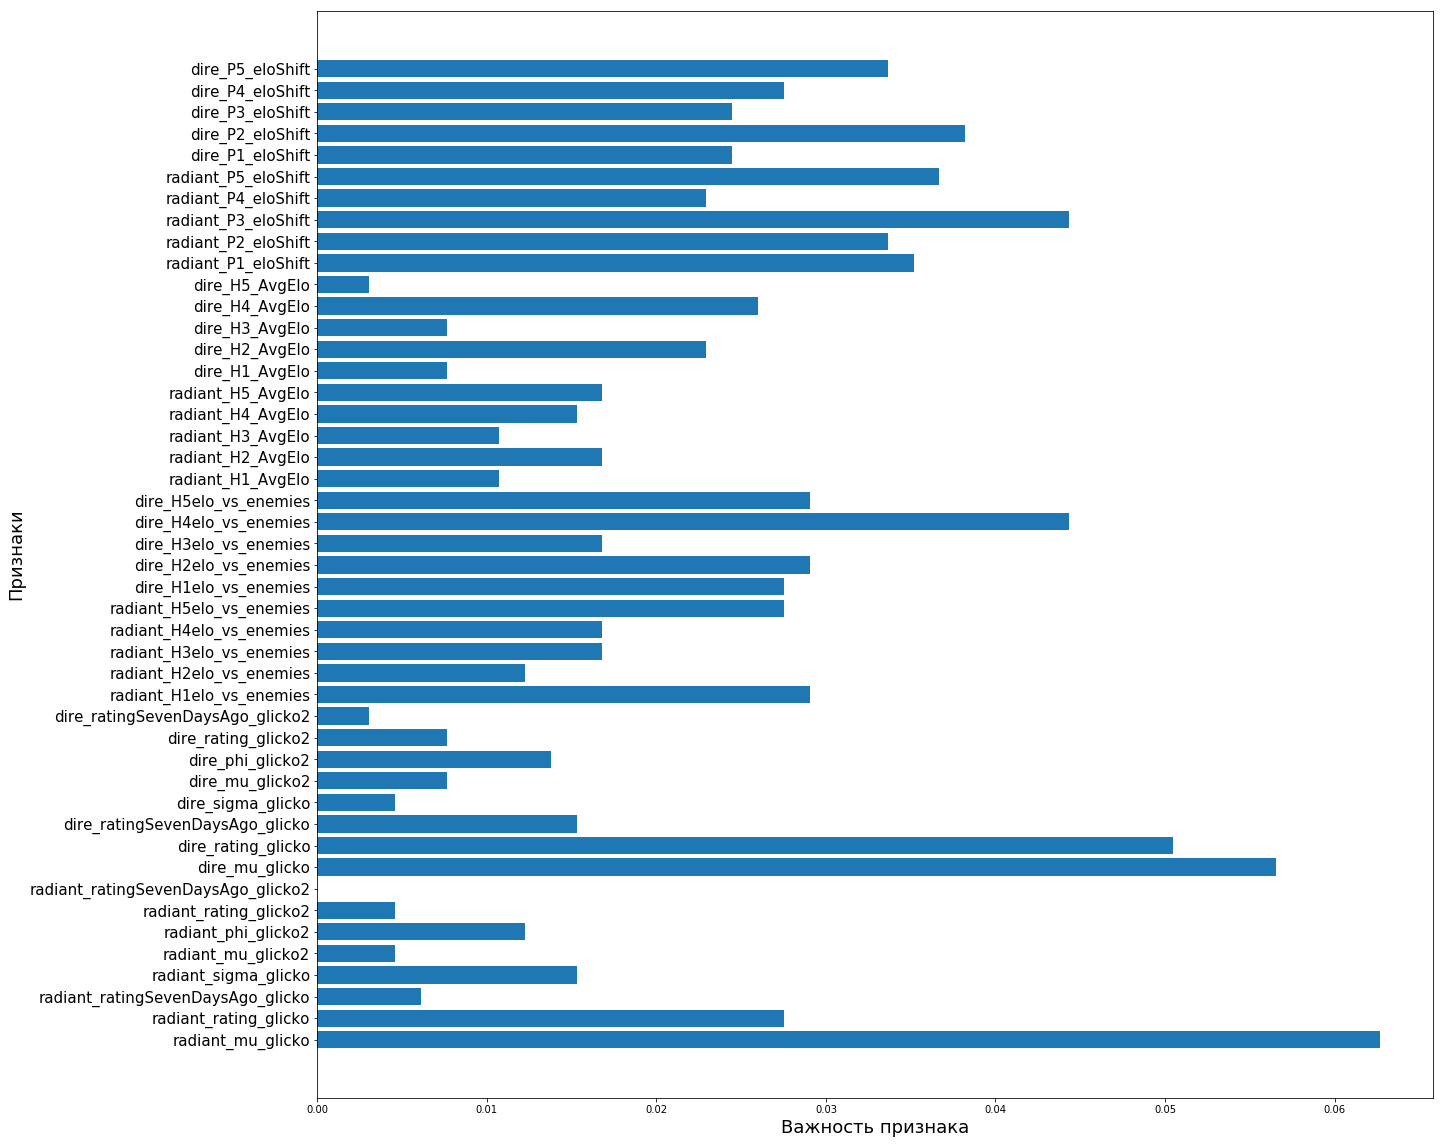

In [151]:
# важность признаков в бустинге

n_features = X_train.shape[1]

plt.figure(figsize=(20,20))
plt.barh(range(n_features), best_GB.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns, fontsize=15)
plt.xlabel('Важность признака', fontsize=18)
plt.ylabel('Признаки', fontsize=18)
plt.show()

In [30]:
# n_features = X_train_selected.shape[1]
# plt.figure(figsize=(20,100))
# plt.barh(range(n_features), best_GB_selected_70.feature_importances_, align='center')
# plt.yticks(np.arange(n_features))
# plt.xlabel('Важность признака')
# plt.ylabel('Признаки')
# plt.show()


# Проверка на новых данных

In [152]:
# дф с матчами и рейтингом каждой команды с патча 7.01 для Премиум
df_rating_teams_Premium_contr = pd.read_csv('../tabel/table from Datdota/Rating teams/'+
                                      'PREMIUM on 2018-03-01 to 2018-04-08 (PreDay).csv', index_col=0)

# ДФ с контрпиками (head-to-head, PRO, >20) с 6,74-7,12 и до 2018.10.01
df_contrpick_contr = pd.read_csv(('../tabel/table from Datdota/Heah-to-head Contrpicks/'+
                'data from 6.74-last. on 2018-03-01 to 2018-04-08 (PreDay, Pro, more 20).csv'), index_col=0)

# ДФ с метовыми героями (PRO, >10)
df_meta_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                             'Meta on 2018-03-01 to 2018-04-08 (PreDAy, Pro, more 10).csv', index_col=0)

# ДФ с сигнатурками для каждого игрока (ALL, >5)
df_signatures_heroes_contr = pd.read_csv('../tabel/table from Datdota/AvgElo Meta and Signatures Heroes/'+
                    'Players Signatures on 2018-03-01 to 2018-04-08 (PreDay, more 5).csv', index_col=0)


In [153]:
df_signatures_heroes_contr = df_signatures_heroes_contr[['radiant_P1_eloShift', 'radiant_P2_eloShift', 'radiant_P3_eloShift', 
                                            'radiant_P4_eloShift', 'radiant_P5_eloShift', 'dire_P1_eloShift', 
                                            'dire_P2_eloShift', 'dire_P3_eloShift', 'dire_P4_eloShift', 
                                            'dire_P5_eloShift', 'match_id']]
# Соединение всех данных в один ДФ
contr = pd.merge(df_rating_teams_Premium_contr, df_contrpick_contr, left_on='match_id', right_on='match_id',how='left')
contr = pd.merge(contr, df_meta_heroes_contr, left_on='match_id', right_on='match_id',how='left')
contr = pd.merge(contr, df_signatures_heroes_contr, left_on='match_id', right_on='match_id',how='left')

# # удаление не нужных колонок для обучения
contr = contr.drop(['match_id', 'start_time', 'radiant_team_id', 'radiant_score', 'dire_team_id',
           'dire_score', 'radiant_name', 'dire_name','league_name'], axis=1)
contr = contr.drop(contr.loc[:, 'radiant_H1' : 'dire_P5'], axis=1)


# Оставляю только важные фичи, убираю из рейтинга команд ело32 и ело64
contr = contr.drop(contr.loc[:, 'radiant_current_elo32':'radiant_thirtyDayAvg_elo64'], axis=1)
contr = contr.drop(contr.loc[:, 'dire_current_elo32':'dire_thirtyDayAvg_elo64'], axis=1)

len(contr)

451

In [154]:
# Заполнить пустые значения на 0
contr = contr.fillna(0)

# # убрать пустые ячейки
# contr = contr.dropna()
len(contr)

451

In [155]:
# Создание контрольной выборки
# Cделать обучающие данные и ответы
X_contr = contr.drop(['radiant_win'], axis=1)
y_contr = contr['radiant_win']

# СДЕЛАТЬ 1 или 0 вместо true false
y_contr = y_contr.astype(int)
X_contr.columns

Index(['radiant_mu_glicko', 'radiant_rating_glicko',
       'radiant_ratingSevenDaysAgo_glicko', 'radiant_sigma_glicko',
       'radiant_mu_glicko2', 'radiant_phi_glicko2', 'radiant_rating_glicko2',
       'radiant_ratingSevenDaysAgo_glicko2', 'dire_mu_glicko',
       'dire_rating_glicko', 'dire_ratingSevenDaysAgo_glicko',
       'dire_sigma_glicko', 'dire_mu_glicko2', 'dire_phi_glicko2',
       'dire_rating_glicko2', 'dire_ratingSevenDaysAgo_glicko2',
       'radiant_H1elo_vs_enemies', 'radiant_H2elo_vs_enemies',
       'radiant_H3elo_vs_enemies', 'radiant_H4elo_vs_enemies',
       'radiant_H5elo_vs_enemies', 'dire_H1elo_vs_enemies',
       'dire_H2elo_vs_enemies', 'dire_H3elo_vs_enemies',
       'dire_H4elo_vs_enemies', 'dire_H5elo_vs_enemies', 'radiant_H1_AvgElo',
       'radiant_H2_AvgElo', 'radiant_H3_AvgElo', 'radiant_H4_AvgElo',
       'radiant_H5_AvgElo', 'dire_H1_AvgElo', 'dire_H2_AvgElo',
       'dire_H3_AvgElo', 'dire_H4_AvgElo', 'dire_H5_AvgElo',
       'radiant_P1_eloShift

In [100]:
# gb_auc_contr = metrics.roc_auc_score(y_contr, best_GB.predict_proba(X_contr)[:,1])
# print('AUC для градиентного бустинга - {:.3f}'.format(gb_auc_contr))

In [101]:
# y_contr_lower_threshold = best_GB.predict_proba(X_contr)[:,1] > .5
# print (classification_report(y_contr, y_contr_lower_threshold))

In [156]:

print(classification_report(y_contr, XGB.predict(X_contr), target_names=['dire_win', 'radiant_win']))

             precision    recall  f1-score   support

   dire_win       0.58      0.61      0.60       188
radiant_win       0.71      0.69      0.70       263

avg / total       0.66      0.66      0.66       451



In [104]:
filename = 'grid_search_GB_model_allData_2018.05.06.sav'
grid_search_GB = pickle.load(open(filename, 'rb'))
print(classification_report(y_contr, grid_search_GB.predict(X_contr), target_names=['dire_win', 'radiant_win']))